### Can you generate faces?
##### We expect you to use images to generate new ones with VAE. You have to write a dataloader to read images from the folder 'faces/', write a VAE class, a loss function, a training loop, and visualize your generated images. 

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import imageio as Image
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

### Nothing to change here (This cell downloads and unzips the data). 

In [ ]:
!wget https://www.dropbox.com/s/4i466z18wsfvefl/faces.zip

!unzip faces.zip

!ls

## Dataloader
####  Write a dataloader to read images from the folder 'faces/' (Note that the transform *trans* resizes the images to 32x32) 

In [3]:
import imageio as iio
trans = transforms.Compose([transforms.ToTensor()
                  ,transforms.Resize([32,32])])

# Replace the question marks '?' by the necessary code
batch_size = 64

class MyDataset(Dataset):
  def __init__(self, image_path, transform = trans):
    self.image_path = image_path
    self.images = os.listdir(image_path)
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    im = iio.imread(f"{self.image_path}{self.images[idx]}")
    print(f"{self.image_path}{self.images[idx]}")
    im = np.array(im)
    im = self.transform(im)
    return im

In [4]:
import imageio.v2 as iio
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import numpy as np

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([32, 32], antialias=True)
])

batch_size = 64

class MyDataset(Dataset):
    def __init__(self, image_path, transform=trans):
        self.image_path = image_path
        self.images = os.listdir(image_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        im = iio.imread(f"{self.image_path}{self.images[idx]}")
        im = np.array(im)
        im = self.transform(im)
        label = torch.tensor(0)  #return empty labels
        return im ,label
dataset = MyDataset("faces/")

train_loader = DataLoader(dataset, batch_size=batch_size)
batch = next(iter(train_loader))
print(batch[0].shape)  # Prints (64, 3, 32, 32)
print(batch[1].shape)  # Prints (64,)


torch.Size([64, 3, 32, 32])
torch.Size([64])


#### Visualize the data
##### Get a batch from the dataloader and visualize its images

torch.Size([64, 3, 32, 32])


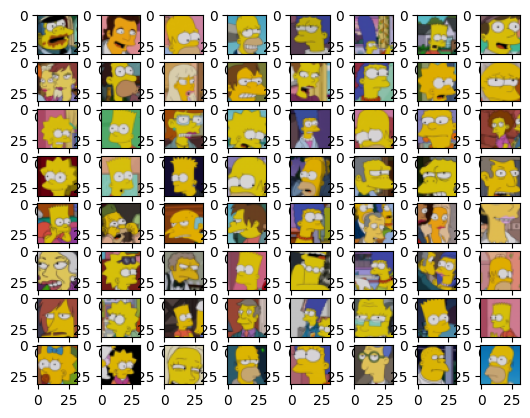

In [5]:
tl = iter(train_loader)
batch = next (tl)
print(batch[0].shape)
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(batch[0][i,:,:,:].permute(1, 2, 0))

### VAE class
#### Write a VAE class in the following cell

In [17]:
# ADD CODE HERE 
class VAE(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.nz = nz
    self.econv1 = nn.Conv2d(3, 16, 3, 1, 1)# --> 16 , 32, 32
    self.ebn1 = nn.BatchNorm2d(16)
    self.econv2 = nn.Conv2d(16, 32, 3, 2, 1)
    self.ebn2 = nn.BatchNorm2d(32)
    self.econv3 = nn.Conv2d(32, 64, 3, 2, 1)
    self.ebn3 = nn.BatchNorm2d(64)
  

    self.elinear1 = nn.Linear(64*8*8, 100)
    self.ebn4 = nn.BatchNorm1d(100)
    self.elinear2 = nn.Linear(100, self.nz)
    
    self.dlinear1 = nn.Linear(self.nz, 100)
    self.dbn1 = nn.BatchNorm1d(100)
    self.dlinear2 = nn.Linear(100, 64*8*8)
    self.dbn2 = nn.BatchNorm1d(64*8*8)
    self.dtconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding = 1)
    self.dbn3 = nn.BatchNorm2d(32)
    self.dtconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding = 1)
    self.dbn4 = nn.BatchNorm2d(16)
    self.dtconv3 = nn.ConvTranspose2d(16, 3, 3, 1, 1)


    self.plinear1 = nn.Linear(self.nz, self.nz)
    self.plinear2 = nn.Linear(self.nz, self.nz)


  def encoder_head(self, x):
    # --> 16 , 32, 32 
    x = torch.relu(self.econv1(x))
    x = self.ebn1(x)
    # --> 32 , 16, 16
    x = torch.relu(self.econv2(x))
    x = self.ebn2(x)
    # --> 64 , 8, 88   
    x = torch.relu(self.econv3(x))
    x = self.ebn3(x)

    x = x.view(-1,64*8*8)

    x = torch.relu(self.elinear1(x))
    x = self.ebn4(x)

    x = torch.sigmoid(self.elinear2(x))
    return x


  def get_params(self, x):
    mu = self.plinear1(x)
    logvar = self.plinear2(x)
    return mu, logvar

  def encoder(self, x):
    x = self.encoder_head(x)
    mu, logvar = self.get_params(x)
    z = torch.exp(0.5*logvar) * torch.randn_like(logvar) + mu #the sampling
    return z, mu, logvar

  def decoder(self, x):
    x = torch.relu(self.dlinear1(x))
    x = self.dbn1(x)

    x = torch.relu(self.dlinear2(x))
    x = self.dbn2(x)

    x = x.view(-1, 64,8,8)

    x = torch.relu(self.dtconv1(x))
    x = self.dbn3(x)

    x = torch.relu(self.dtconv2(x))
    x = self.dbn4(x)

    x = torch.sigmoid(self.dtconv3(x))

    return x


  def forward(self, x):
    z, mu, logvar = self.encoder(x)
    x = self.decoder(z)
    return z, x, mu, logvar

## Loss 
#### Define Loss function in the following cell

In [7]:
# ADD CODE HERE 
def get_loss(x, xhat, mu, logvar):
  m = 1e-4
  recon_loss = F.mse_loss(x,xhat)
  kld_loss = torch.mean(torch.sum(-0.5*(1+logvar - torch.exp(logvar)- mu**2), dim=1), dim=0)
  loss = m * kld_loss + (1-m) * recon_loss
  return loss


### Training Loop
#### Define optimizer, write the training loop in the following cell, and plot the loss

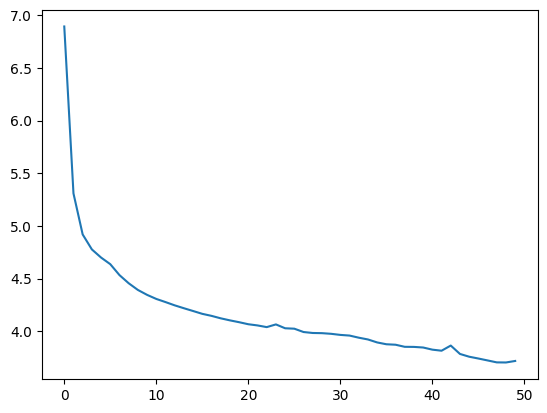

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = VAE(10).to(device)
num_epochs = 50
lr = 1e-2
opt = optim.Adam(net.parameters(), lr = lr)
#opt = SophiaG(net.parameters(), lr=2e-4, betas=(0.965, 0.99), rho = 0.01, weight_decay=1e-1)

ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X = batch[0].to(device)
    Z, Xhat, mu, logvar = net(X)
    loss = get_loss(Xhat, X, mu, logvar)
    total_loss+= loss.item()
    opt.zero_grad()
    loss.backward()
    opt.step()
  ls.append(total_loss)
plt.plot(ls)

In [20]:
# ADD CODE HERE
with torch.no_grad():
  net.eval()
  z = torch.randn(64, 10).to(device)

  Xgen = net.decoder(z)

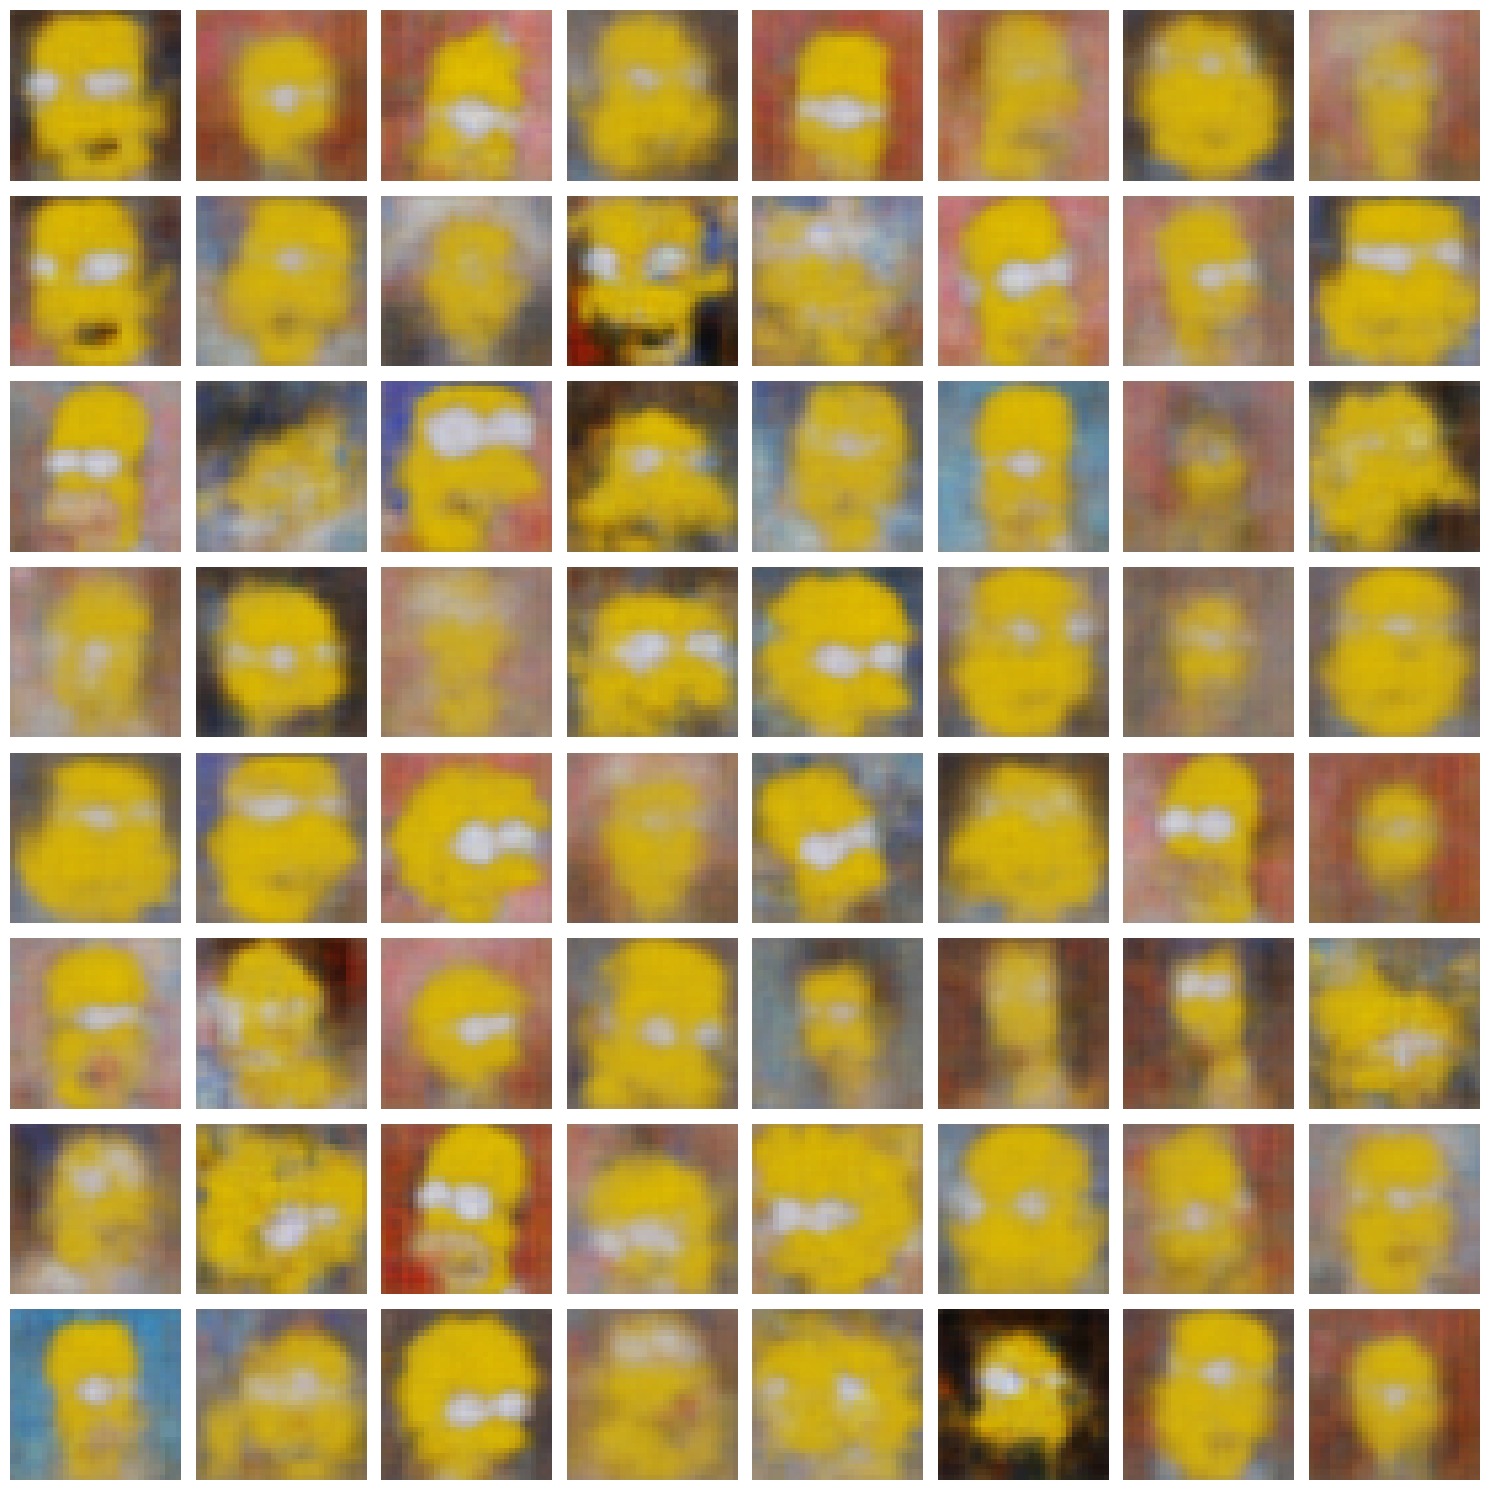

In [21]:
# Plot the generated images
fig, axs = plt.subplots(8, 8, figsize=(15, 15))
for i in range(64):
    image = Xgen[i].permute(1, 2, 0)  # Convert tensor shape from (3, 32, 32) to (32, 32, 3)
    axs[i // 8, i % 8].imshow(image.cpu())
    axs[i // 8, i % 8].axis('off')

plt.tight_layout()
plt.show()

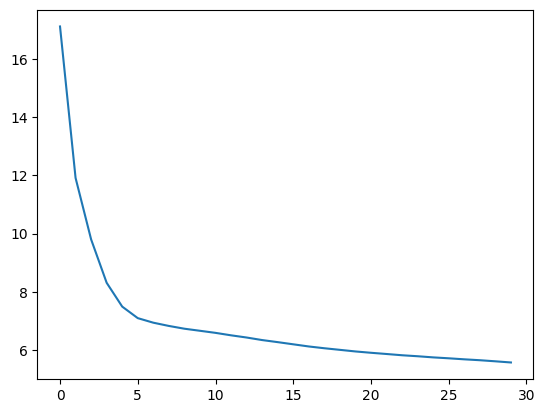

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = VAE(10).to(device)
num_epochs = 30
lr = 1e-4
opt = optim.Adam(net.parameters(), lr = lr)
#opt = SophiaG(net.parameters(), lr=2e-4, betas=(0.965, 0.99), rho = 0.01, weight_decay=1e-1)

ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X = batch[0].to(device)
    Z, Xhat, mu, logvar = net(X)
    loss = get_loss(Xhat, X, mu, logvar)
    total_loss+= loss.item()
    opt.zero_grad()
    loss.backward()
    opt.step()
  ls.append(total_loss)
plt.plot(ls)


## Generate and Plot Data
#### Generate a batch of 64 images and plot them in subplots of 8 rows and 8 columns.

In [9]:
# ADD CODE HERE
with torch.no_grad():
  net.eval()
  z = torch.randn(64, 10).to(device)

  Xgen = net.decoder(z)

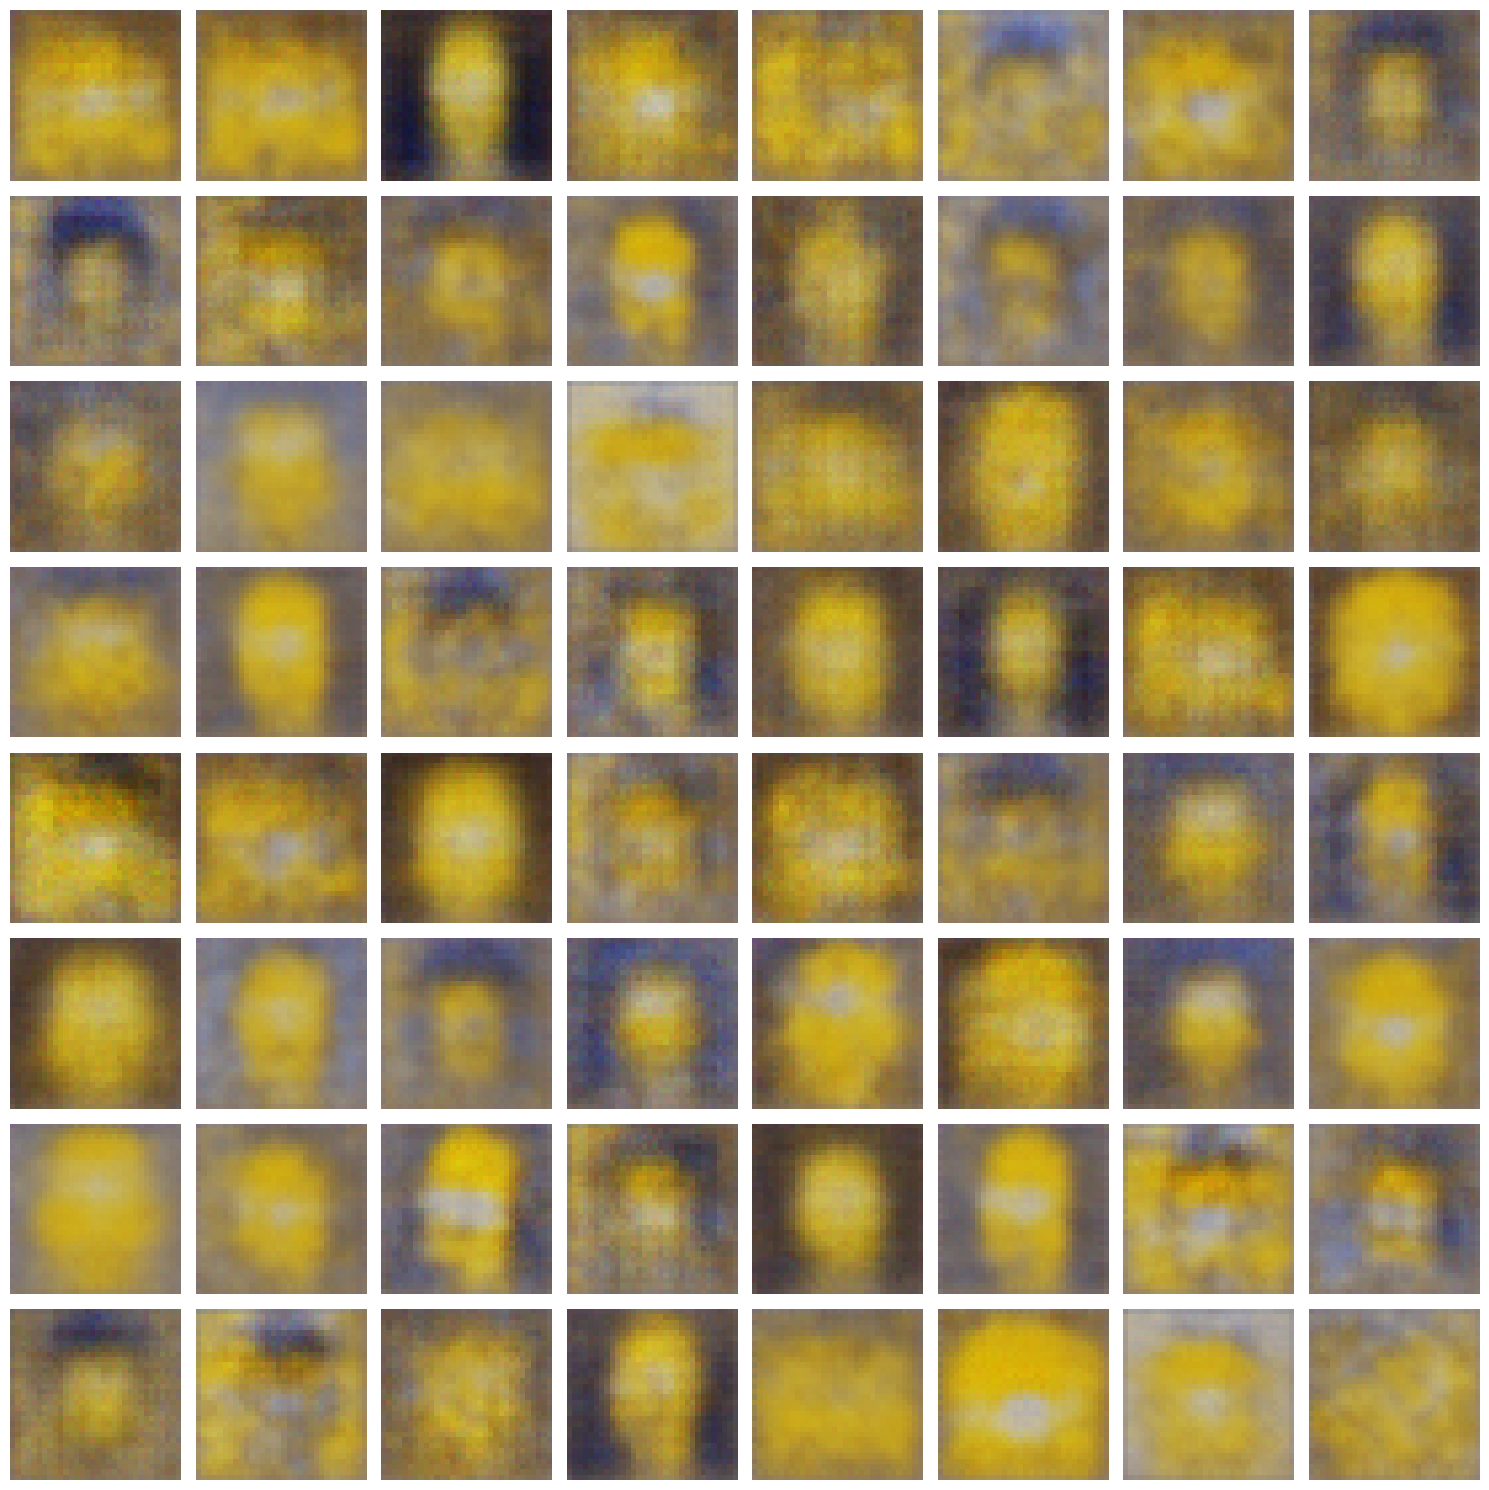

In [10]:
# Plot the generated images
fig, axs = plt.subplots(8, 8, figsize=(15, 15))
for i in range(64):
    image = Xgen[i].permute(1, 2, 0)  # Convert tensor shape from (3, 32, 32) to (32, 32, 3)
    axs[i // 8, i % 8].imshow(image.cpu())
    axs[i // 8, i % 8].axis('off')

plt.tight_layout()
plt.show()

try another code 

In [13]:
# ADD CODE HERE 
class VAE(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.nz = nz
    self.econv1 = nn.Conv2d(3, 16, 3, 1, 1)# --> 16 , 32, 32
    self.ebn1 = nn.BatchNorm2d(16)
    self.econv2 = nn.Conv2d(16, 32, 3, 2, 1) # --> 32 ,16,16
    self.ebn2 = nn.BatchNorm2d(32)
    self.econv3 = nn.Conv2d(32, 64, 3, 2, 1)# --> 64 ,8,8
    self.ebn3 = nn.BatchNorm2d(64)

  

    self.elinear1 = nn.Linear(64*8*8, 1000)
    self.ebn4 = nn.BatchNorm1d(1000)
    self.elinear2 = nn.Linear(1000, 500)
    self.ebn5 = nn.BatchNorm1d(500)
    self.elinear3 = nn.Linear(500, 100)
    self.ebn6 = nn.BatchNorm1d(100)
    self.elinear4 = nn.Linear(100, self.nz)
    
    #
    self.dlinear1 = nn.Linear(self.nz, 100)
    self.dbn1 = nn.BatchNorm1d(100)
    self.dlinear2 = nn.Linear(100, 500)
    self.dbn2 = nn.BatchNorm1d(500)

    self.dlinear3 = nn.Linear(500, 1000)
    self.dbn3 = nn.BatchNorm1d(1000)
    self.dlinear4 = nn.Linear(1000, 64*8*8)
    self.dbn4 = nn.BatchNorm1d(64*8*8)

    self.dtconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding = 1)
    self.dbn5 = nn.BatchNorm2d(32)
    self.dtconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding = 1)
    self.dbn6 = nn.BatchNorm2d(16)
    self.dtconv3 = nn.ConvTranspose2d(16, 3, 3, 1, 1)


    self.plinear1 = nn.Linear(self.nz, self.nz)
    self.plinear2 = nn.Linear(self.nz, self.nz)


  def encoder_head(self, x):
    # --> 16 , 32, 32 
    x = torch.relu(self.econv1(x))
    x = self.ebn1(x)
    # --> 32 , 16, 16
    x = torch.relu(self.econv2(x))
    x = self.ebn2(x)
    # --> 64 , 8, 88  
    x = torch.relu(self.econv3(x))
    x = self.ebn3(x)

    x = x.view(-1,64*8*8)

    x = torch.relu(self.elinear1(x))
    x = self.ebn4(x)

    x = torch.relu(self.elinear2(x))
    x = self.ebn5(x)

    x = torch.relu(self.elinear3(x))
    x = self.ebn6(x)

    x = torch.sigmoid(self.elinear4(x))
    return x


  def get_params(self, x):
    mu = self.plinear1(x)
    logvar = self.plinear2(x)
    return mu, logvar

  def encoder(self, x):
    x = self.encoder_head(x)
    mu, logvar = self.get_params(x)
    z = torch.exp(0.5*logvar) * torch.randn_like(logvar) + mu #the sampling
    return z, mu, logvar

  def decoder(self, x):
    x = torch.relu(self.dlinear1(x))
    x = self.dbn1(x)

    x = torch.relu(self.dlinear2(x))
    x = self.dbn2(x)

    x = torch.relu(self.dlinear3(x))
    x = self.dbn3(x)

    x = torch.relu(self.dlinear4(x))
    x = self.dbn4(x)

    x = x.view(-1, 64,8,8)

    x = torch.relu(self.dtconv1(x))
    x = self.dbn5(x)

    x = torch.relu(self.dtconv2(x))
    x = self.dbn6(x)

    x = torch.sigmoid(self.dtconv3(x))

    return x


  def forward(self, x):
    z, mu, logvar = self.encoder(x)
    x = self.decoder(z)
    return z, x, mu, logvar

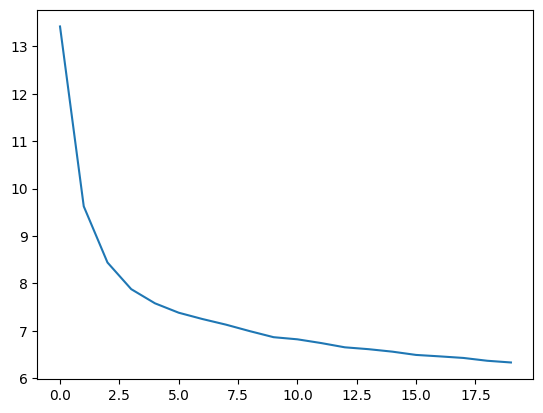

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = VAE(10).to(device)
num_epochs = 20
lr = 1e-4
opt = optim.Adam(net.parameters(), lr = lr)
#opt = SophiaG(net.parameters(), lr=2e-4, betas=(0.965, 0.99), rho = 0.01, weight_decay=1e-1)

ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X = batch[0].to(device)
    Z, Xhat, mu, logvar = net(X)
    loss = get_loss(Xhat, X, mu, logvar)
    total_loss+= loss.item()
    opt.zero_grad()
    loss.backward()
    opt.step()
  ls.append(total_loss)
plt.plot(ls)


In [15]:
# ADD CODE HERE
with torch.no_grad():
  net.eval()
  z = torch.randn(64, 10).to(device)

  Xgen = net.decoder(z)

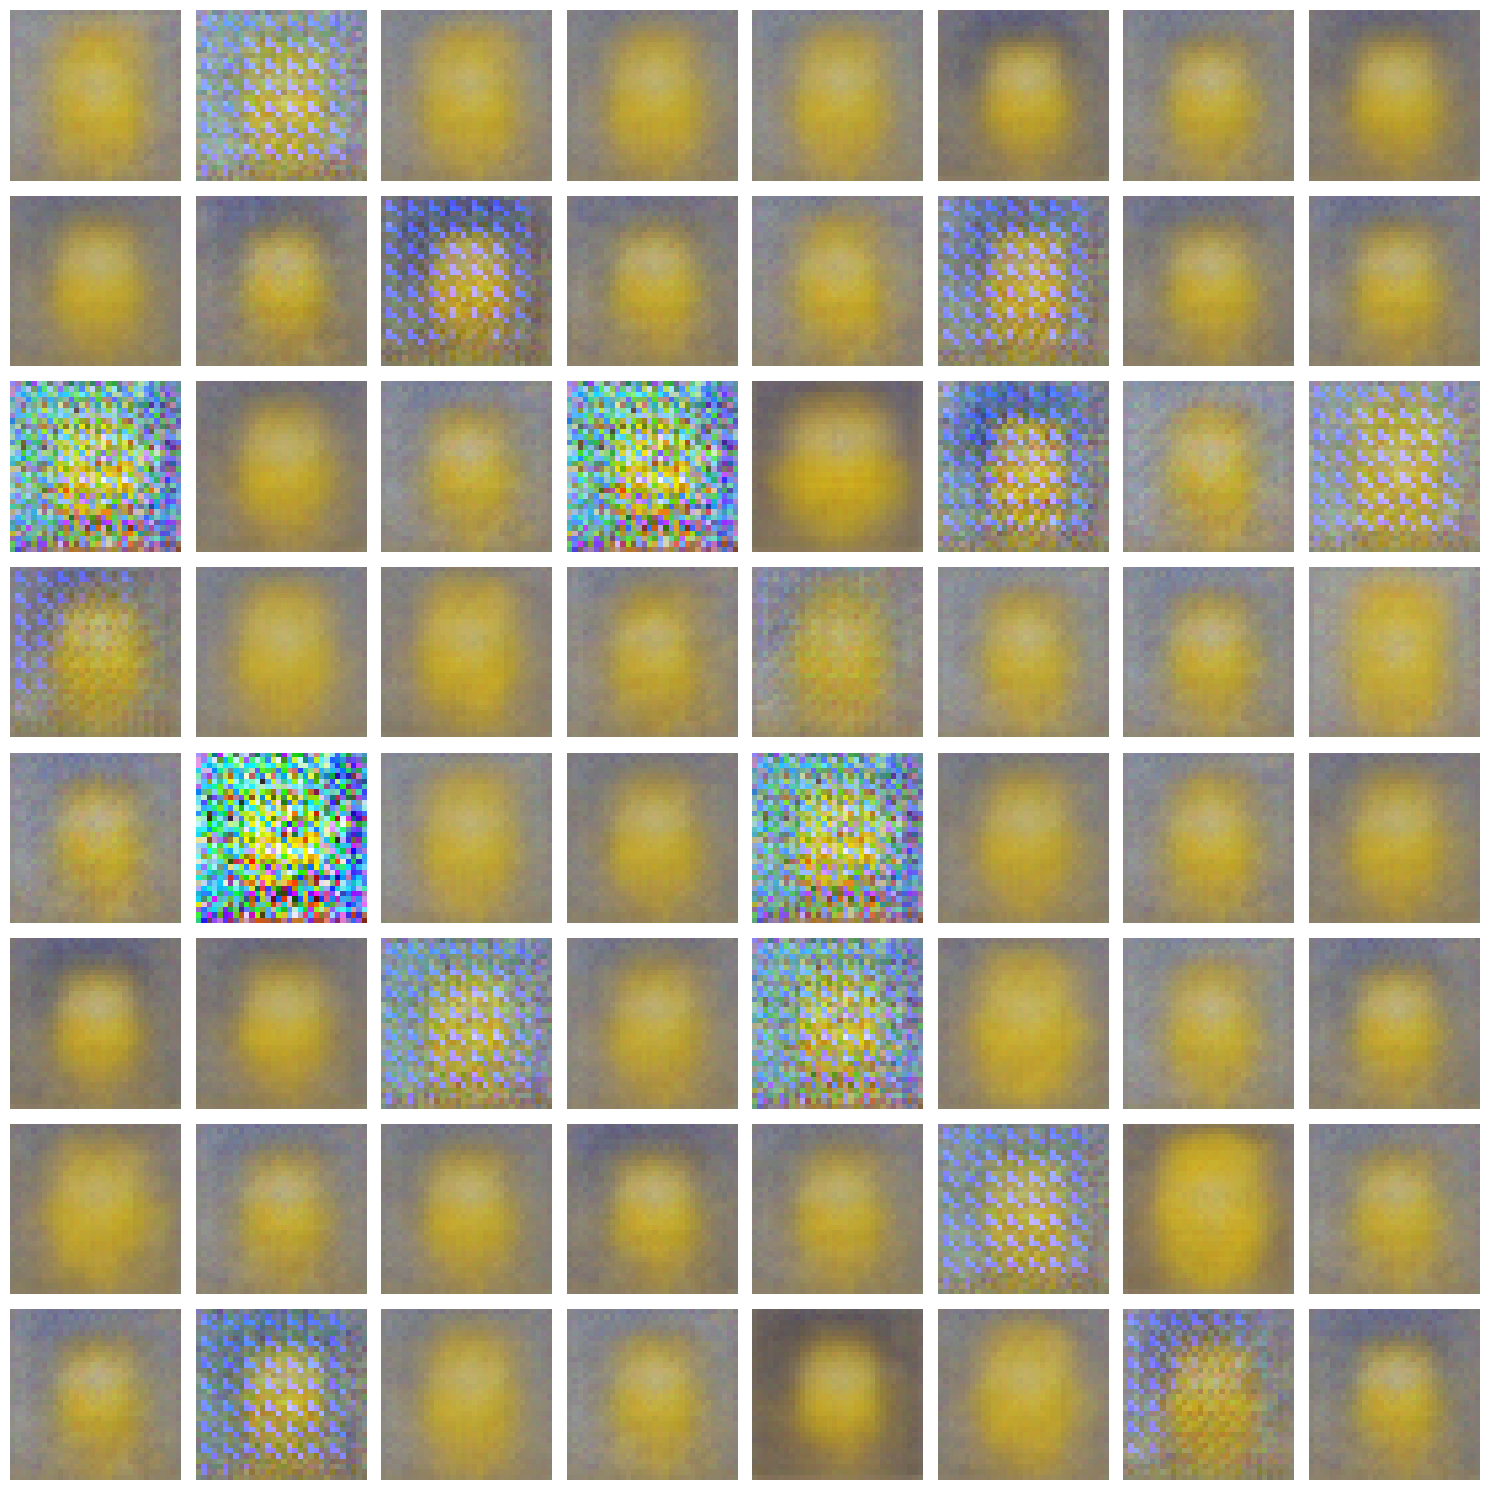

In [16]:
# Plot the generated images
fig, axs = plt.subplots(8, 8, figsize=(15, 15))
for i in range(64):
    image = Xgen[i].permute(1, 2, 0)  # Convert tensor shape from (3, 32, 32) to (32, 32, 3)
    axs[i // 8, i % 8].imshow(image.cpu())
    axs[i // 8, i % 8].axis('off')

plt.tight_layout()
plt.show()